In [50]:
from theano import tensor as T
import lasagne_dev as nn
import numpy as np
import pickle
from input_process import read_images
import random
import math
import cmath
from g_gradient import *
from collections import OrderedDict
%matplotlib inline
import matplotlib.pyplot as plt
import os

In [ ]:
size = (116, 116)
pkl_file = open('../fnames_collection_2', 'r')
fnames = pkl_file.readline()
fnames = fnames.split(' ')
for i in range (0,len(fnames)):
	fnames[i] = str(fnames[i])
	fnames[i] = 'image' + fnames[i] + '.png'

train_index = fnames[0:5]

label_path = '../NewPNGlabeled/'
ori_path = '../JpegOriginalImg/'
train_input, train_label = read_images(label_path, ori_path, train_index, size)
#test_input, test_label, shape = read_images(label_path, ori_path, test_index, size)

input_var = train_input
label_var = train_label
shape = [5,1,116,116]
layer = nn.layers.InputLayer(shape,input_var)
layer = nn.layers.gabor_Conv2DLayer(layer, num_filters = 4,filter_size = 7,
                              nonlinearity = nn.nonlinearities.sigmoid, pad = 'same') #116 
layer = nn.layers.gabor_Conv2DLayer(layer, num_filters = 8,filter_size = 7,
                              nonlinearity = nn.nonlinearities.sigmoid, pad = 'same')
layer = nn.layers.Conv2DLayer(layer, num_filters = 1,filter_size = 7,
                              nonlinearity = nn.nonlinearities.sigmoid, pad = 'same') #116 


In [ ]:
output = nn.layers.get_output(layer) # parameters will be updated - use for train
#output_det = nn.layers.get_output(layer, deterministic=True) 
params = nn.layers.get_all_params(layer)
gs = nn.layers.get_all_gs(layer)
loss = -2*T.sum(output*label_var)/T.sum(output+label_var+0.0001)
rand = 1


In [ ]:
def g_updates_dev(loss, params, gs, rand, lr=0.001):
    gs_gradients = []
    gradients = nn.updates.get_or_compute_grads(loss, params)
    
    for w_index in range (0, 2):
        # First Loop
        # print(w_index)
        
        ws = params[w_index*2]
        g_params = gs[w_index]
        ws_gradients = gradients[w_index*2]

        [num_filters, num_channels, filter_size, filter_size] = ws.get_value().shape
        
        position = int(math.floor(filter_size/2))
        ws_grad = ws_gradients[:,:,position:position+1,position]

        # select which parameter to update
        #rand = random.randint(1,3)
        # rand = 1
        which_parameter = np.array([[1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0],[0,0,0,0,1]][rand-1])
        fns = [g_f, g_gamma, g_sigma, g_theta, g_psi]
        fn = fns[rand-1]

        # Second and third Loop
        additions = []
        for i in range (0, num_filters):
            for j in range (0, num_channels):
                g = g_params[i,j,:]
                additions.append(fn(0,0,g))
                #additions.append(calculate_gradient_for_g(fn,g,filter_size))
                
        additions = theano.tensor.stack(additions).reshape([num_filters,num_channels,-1])
        gp_list = np.array([ws_grad, ws_grad, ws_grad, ws_grad, ws_grad])*which_parameter
        gp = theano.tensor.concatenate(np.ndarray.tolist(gp_list), axis=2)
        gs_gradient = []
        for i in range(0,num_filters):
            for j in range(0,num_channels):
                gs_gradient.append(gp[i,j,:]*additions[i,j,0])

        gs_gradients.append(theano.tensor.concatenate(gs_gradient, axis=0).reshape([num_filters,num_channels,-1]))
    gs_updates = nn.updates.adam_dev(gs_gradients, gs, learning_rate=lr)
    return gs_updates

In [ ]:
gs_updates = g_updates_dev(loss, params, gs, rand)

In [ ]:
updates = OrderedDict()
lr = theano.shared(nn.utils.floatX(1e-4)) # learning rate
updates_old = nn.updates.adam(loss, params, learning_rate=lr)
for i in range (0,len(gs)):
    print(i)
    gs_new = gs_updates[gs[i]]
    #gs_new.dtype = np.float32
    ws = params[i*2]
    [num_filters, num_channels, filter_size, filter_size] = ws.get_value().shape
    W = gabor_weight_update([num_filters, num_channels, filter_size, filter_size], gs_new)
    #updates[ws] = theano.shared(W)
    updates[ws] = W
    updates[params[i*2+1]] = updates_old[params[i*2+1]]
    updates[gs[i]] = gs_new

for j in range (2*len(gs),len(params)):
    updates[params[j]] = updates_old[params[j]]

print(gs_updates[gs[0]].dtype)
gs_new = gs_updates[gs[i]]
ws = params[0*2]
[num_filters, num_channels, filter_size, filter_size] = ws.get_value().shape
W = gabor_weight_update([num_filters, num_channels, filter_size, filter_size], gs_new)
print(W.dtype)

print(updates[params[0]].dtype) 

In [ ]:
gs_gradients = []
gradients = nn.updates.get_or_compute_grads(loss, params)

for w_index in range (0, 2):
    # First Loop
    # print(w_index)

    ws = params[w_index*2]
    g_params = gs[w_index]
    ws_gradients = gradients[w_index*2]

    [num_filters, num_channels, filter_size, filter_size] = ws.get_value().shape

    position = int(math.floor(filter_size/2))
    ws_grad = ws_gradients[:,:,position:position+1,position]

    # select which parameter to update
    #rand = random.randint(1,3)
    # rand = 1
    which_parameter = np.array([[1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0],[0,0,0,0,1]][rand-1])
    fns = [g_f, g_gamma, g_sigma, g_theta, g_psi]
    fn = fns[rand-1]

    # Second and third Loop
    additions = []
    for i in range (0, num_filters):
        for j in range (0, num_channels):
            g = g_params[i,j,:]
            additions.append(fn(0,0,g))
            #additions.append(calculate_gradient_for_g(fn,g,filter_size))

    additions = theano.tensor.stack(additions).reshape([num_filters,num_channels,-1])
    gp_list = np.array([ws_grad, ws_grad, ws_grad, ws_grad, ws_grad])*which_parameter
    gp = theano.tensor.concatenate(np.ndarray.tolist(gp_list), axis=2)
    
    gs_gradient = []
    for i in range(0,num_filters):
        for j in range(0,num_channels):
            gs_gradient.append(gp[i,j,:]*additions[i,j,0])

    gs_gradients.append(theano.tensor.concatenate(gs_gradient, axis=0).reshape([num_filters,num_channels,-1]))
gs_updates = nn.updates.adam_dev(gs_gradients, gs, learning_rate=lr)

In [ ]:
gs_updates[gs[0]].dtype

In [ ]:
gradients = nn.updates.get_or_compute_grads(loss, params)

w_index=0
ws = params[w_index*2]
g_params = gs[w_index]
ws_gradients = gradients[w_index*2]

[num_filters, num_channels, filter_size, filter_size] = ws.get_value().shape

position = int(math.floor(filter_size/2))
ws_grad = ws_gradients[:,:,position:position+1,position]

# select which parameter to update
#rand = random.randint(1,3)
# rand = 1
which_parameter = np.array([[1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0],[0,0,0,0,1]][rand-1])
fns = [g_f, g_gamma, g_sigma, g_theta, g_psi]
fn = fns[rand-1]

# Second and third Loop
additions = []
for i in range (0, num_filters):
    for j in range (0, num_channels):
        g = g_params[i,j,:]
        additions.append(fn(0,0,g))
        #additions.append(calculate_gradient_for_g(fn,g,filter_size))

In [ ]:
addition = theano.tensor.stack(additions).reshape([4,1,-1])
addition.dtype

In [ ]:
#print(ws_grad.eval())
gp_list = np.array([ws_grad, ws_grad, ws_grad, ws_grad, ws_grad])*which_parameter
gp = theano.tensor.concatenate(np.ndarray.tolist(gp_list), axis=2)
gs_gradient = []
for i in range(0,4):
    for j in range(0,1):
        gs_gradient.append(gp[i,j,:]*addition[i,j,0])
#print(gp_list[0].shape.eval(),x.shape.eval())
print(gp.eval(),addition.eval())
#y = [x[0,0,:]*additions[0],x[1,0,:]*additions[1],x[2,0,:]*additions[2],x[3,0,:]*additions[3]]
theano.tensor.concatenate(gs_gradient, axis=0).reshape([4,1,-1]).dtype

In [ ]:
addition=theano.tensor.stack(additions).reshape([4,1,-1])
y = []

z = theano.tensor.concatenate(y)
print(z.eval())

In [ ]:
input_var = train_input
label_var = train_label
shape = [5,1,116,116]
layer = nn.layers.InputLayer(shape,input_var)
layer = nn.layers.gabor_Conv2DLayer(layer, num_filters = 4,filter_size = 3,
                              nonlinearity = nn.nonlinearities.sigmoid, pad = 'same') #116 
layer = nn.layers.gabor_Conv2DLayer(layer, num_filters = 1,filter_size = 3,
                               nonlinearity = nn.nonlinearities.sigmoid, pad = 'same')

In [ ]:
params = nn.layers.get_all_params(layer)
params[0].shape.eval()

In [ ]:
output = nn.layers.get_output(layer) # parameters will be updated - use for train
#output_det = nn.layers.get_output(layer, deterministic=True) 

params = nn.layers.get_all_params(layer)
gs = nn.layers.get_all_gs(layer)
loss = -2*T.sum(output*label_var)/T.sum(output+label_var+0.0001)
#print (loss.eval())

lr = 1 # learning rate
#updates = nn.updates.sgd(loss, params, learning_rate=lr)

In [ ]:
gs_updates = g_updates(loss, params, gs)

In [ ]:
#gs_updates[gs[0]].eval()
value = [gs_updates[gs[i]].eval() for i in range (0,len(gs))]
#gs_updates[gs[0]].get_value()
#updates = nn.updates.sgd(loss, params, learning_rate=lr)
#value[0].eval().shape

In [ ]:
x = theano.shared(0)
x

In [ ]:
#nn.layers.set_all_gs_values(layer, value)
value

In [ ]:
from collections import OrderedDict
updates = OrderedDict()
updates_old = nn.updates.adam(loss, params, learning_rate=lr)
for i in range (0,len(value)):
    gs = value[i]
    ws = params[i*2]
    [num_filters, num_channels, filter_size, filter_size] = np.ndarray.tolist(ws.shape.eval())
    W = nn.layers.gabor.gabor_filter_initiation([num_filters, num_channels, filter_size, filter_size], gs)
    #updates[ws] = theano.shared(W)
    updates[ws] = W
    updates[params[i*2+1]] = updates_old[params[i*2+1]]


In [ ]:
updates[params[0]].eval()

In [ ]:
updates_old = nn.updates.adm(loss, params, learning_rate=lr)
updates_old[params[0]].eval()

In [ ]:
g_gradients = np.array([], dtype=np.float32).reshape(1,-1)
g_gradient = np.array([0,0,0,0,0.11]).reshape(1,-1)
g_gradients = np.concatenate((g_gradients,g_gradient),axis=1)

In [ ]:
from itertools import chain

def get_g(layer):
    if hasattr(layer, 'g'):
        result = layer.g
    else:
        result = []
    result = nn.utils.collect_shared_vars(result)
    return result
    
layers = nn.layers.get_all_layers(layer)

params = chain.from_iterable(get_g(l) for l in layers)
params = nn.utils.unique(params)
value = [g.get_value() for g in params]
value


In [ ]:
params[0].eval()

In [ ]:
updates[params[0]].eval()
gs

In [ ]:
def gabor_filter(x,y,params):
    f,gamma,sigma,theta,psi = params
    xt = x*math.cos(theta) + y*math.sin(theta)
    yt = -x*math.sin(theta) + y*math.cos(theta)
    z1 = -(xt**2 + (gamma*yt)**2)/(2*sigma**2)
    z2 = 1j*2*math.pi*f*xt+psi
    value = f**2/(math.pi*gamma)*math.exp(z1)*cmath.exp(z2)
    return value

def g_theta(x,y,params):
    f,gamma,sigma,theta,psi = params
    value = gabor_filter(x,y,params)
    return ((yt*xt/sigma**2)*(gamma**2-1)+1j*2*math.pi*f*yt)*value

def g_f(x,y,params):
    f,gamma,sigma,theta,psi = params
    value = gabor_filter(x,y,params)  
    return (2/f + 1j*2*math.pi*xt)*value

def g_gamma(x,y,params):
    f,gamma,sigma,theta,psi = params
    value = gabor_filter(x,y,params)  
    return -(yt**2*gamma/sigma**2+1/gamma)*value

def g_theta(x,y,params):
    f,gamma,sigma,theta,psi = params
    value = gabor_filter(x,y,params)  
    return ((xt**2 + gamma**2*yt**2)/sigma**3)*value

def g_psi(x,y,params):
    f,gamma,sigma,theta,psi = params
    value = gabor_filter(x,y,params)  
    return value


def gabor_filter_update(size, params, f):
    bond = math.floor(size/2)
    x_range = np.linspace(-bond, bond, size)
    y_range = np.linspace(-bond, bond, size)

    [x_range,y_range] = list(map(lambda x:x.reshape(1,-1),np.meshgrid(x_range,y_range)))
    gfilter = []
    updates = []
    for (x,y) in zip(np.ndarray.tolist(x_range)[0], np.ndarray.tolist(y_range)[0]):        
        update = f(x,y,params)
        updates.append(update.real)
    updates = np.array(updates, dtype=np.float32).reshape(size,-1)
    return updates

In [ ]:
params = nn.layers.get_all_params(layer)
gradients = nn.updates.get_or_compute_grads(loss, params)
learning_rate = 1

# First Loop
ws_update = updates[params[0]]
g_params = gs[0]
ws = params[0]
ws_gradients = gradients[0]
#print(w_update, g_params)

# Second and third Loop
i = 0
j = 0

g = g_params[i,j,:]
w_update = ws_update[i,j,:,:]
w = ws[i,j,:,:]
filter_size = w.shape.eval()[0]
w_gradient = ws_gradients[i,j,:]
# sgd: calculate gradient from updates
#gradient = (w - w_update)/learning_rate


update_try = gabor_filter_update(filter_size, g.eval(), g_psi)

a = (update_try*w_gradient).sum()
psi_gradient = a/9

psi_gradient.eval()

In [ ]:
gradients = nn.updates.get_or_compute_grads(loss, params)
print((gradients[0].eval())[0,0,:], '\n')
gradient = (w - w_update)/learning_rate
print(gradient.eval())

In [ ]:
#print(update_try, '\n', gradient)
#print(update_try*gradient)
#sum(sum(update_try*gradient))/filter_size**2
from collections import OrderedDict
gradient = nn.updates.get_or_compute_grads(loss, params)
a = OrderedDict()
for param, grad in zip(params, gradient):
    a[param] = param - learning_rate * grad

layer.g.get_value()

In [ ]:
import theano
import theano.tensor as T

def adam_dev(gradient, params, learning_rate=0.001, beta1=0.9,
         beta2=0.999, epsilon=1e-8):
    all_grads = gradient
    t_prev = theano.shared(nn.utils.floatX(0.))
    updates = OrderedDict()

    # Using theano constant to prevent upcasting of float32
    one = T.constant(1)

    t = t_prev + 1
    a_t = learning_rate*T.sqrt(one-beta2**t)/(one-beta1**t)

    for param, g_t in zip(params, all_grads):
        value = param.get_value(borrow=True)
        m_prev = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                               broadcastable=param.broadcastable)
        v_prev = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                               broadcastable=param.broadcastable)

        m_t = beta1*m_prev + (one-beta1)*g_t
        v_t = beta2*v_prev + (one-beta2)*g_t**2
        step = a_t*m_t/(T.sqrt(v_t) + epsilon)

        updates[m_prev] = m_t
        updates[v_prev] = v_t
        updates[param] = param - step

    updates[t_prev] = t
    return updates

In [ ]:
psi_gradient.eval()
g_gradient = np.array([0,0,0,0,psi_gradient.eval()])
g_gradient = theano.shared(nn.utils.floatX(g_gradient))

g_updates = adam_dev([g_gradient], [gs[0]])
print(g_updates[gs[0]].eval(),'\n')
print(gs[0].eval())

In [ ]:
x = nn.updates.get_or_compute_grads(loss, params)
x[0].eval()

In [ ]:
[num_filters, num_channels, size, size] = w_update.shape
for i in range (0, num_filters):
    for j in range (0, num_channels):
        g_params = gs[i,j,:]

In [ ]:
w_1 = np.random.normal(0, 0.01, (3, 3))
w_2 = np.random.normal(0, 0.02, (3, 3))
a_1 = w_1.reshape(1,-1)
a_2 = w_2.reshape(1,-1)
ve = np.concatenate((a_1,a_2),axis=1)
w_init = ve.reshape(2,1,3,3)

In [ ]:
w_init


In [ ]:
pkl_file = open('/Users/apple/Documents/Lab_Winter/GDCNN/scripts/params_epoch_400', 'rb')
params = pickle.load(pkl_file)
params[4][1]

In [ ]:
w1 = np.ones([3,3])
w1 = w1.reshape(-1,3,3)
w2 = np.ones([3,3])*2
w2 = w2.reshape(-1,3,3)
W_filter1 = np.concatenate((w1,w2),axis=0)

w1 = np.ones([3,3])
w1 = w1.reshape(-1,3,3)
w2 = np.ones([3,3])*2
w2 = w2.reshape(-1,3,3)
W_filter2 = np.concatenate((w1,w2),axis=0)

w1 = np.ones([3,3])
w1 = w1.reshape(-1,3,3)
w2 = np.ones([3,3])*2
w2 = w2.reshape(-1,3,3)
W_filter3 = np.concatenate((w1,w2),axis=0)

Ws = np.concatenate((W_filter1.reshape(-1,2,3,3),W_filter2.reshape(-1,2,3,3),W_filter3.reshape(-1,2,3,3)),axis=0)



In [ ]:
# if we want to initial weight of [2,2,3,3]
shape = [2,2,3,3]
[NumChannel,NumFilter,size,size] = shape

Ws = np.array([]).reshape(1,-1)
for i in range (0,NumFilter*NumFilter):
    w = np.ones([3,3]).reshape(1,-1) # np.ones([3,3]) can be replaced by other functions
    Ws = np.concatenate((Ws,w),axis=1)
Ws = Ws.reshape(2,2,3,3)
Ws

In [ ]:
shape = [2,2,3,3]
[NumChannel,NumFilter,size,size] = shape
NumChannel

In [ ]:
import theano
from theano import tensor as T
from theano import pp
x = T.dscalar('x')
y = T.dscalar('y')
z = x ** 2 + y ** 2
gz = T.grad(z,x)
f = theano.function([x,y],gz)
pp(f.maker.fgraph.outputs[0])

#f = theano.function([x,y],gz)
#pp(f.maker.fgraph.outputs[1])



In [ ]:
import numpy as np
nx, ny = (3, 2)
x = np.linspace(-1, 1, 3)
y = np.linspace(-1, 1, 3)
xv, yv = np.meshgrid(x, y)
xv.reshape(1,-1), yv.reshape(1,-1)
for i in x:
    print(i)

In [ ]:
x = np.linspace(-1, 1, 3)
y = np.linspace(-1, 1, 3)
[x,y] = list(map(lambda x:x.reshape(1,-1),np.meshgrid(x,y)))
print(math.floor(3/2))

In [ ]:
f = random.uniform(0.0001,2)
gamma = random.uniform(0.0001,1)
sigma = random.uniform(0.0001,2)
theta = random.uniform(0,2*math.pi)    
psi = random.uniform(0.0001,2)
    
bond = math.floor(size/2)
x_range = np.linspace(-bond, bond, size)
y_range = np.linspace(-bond, bond, size)

[x_range,y_range] = list(map(lambda x:x.reshape(1,-1),np.meshgrid(x_range,y_range)))
gfilter = []
for (x,y) in zip(np.ndarray.tolist(x_range)[0], np.ndarray.tolist(y_range)[0]):
    xt = x*math.cos(theta) + y*math.sin(theta)
    yt = -x*math.sin(theta) + y*math.cos(theta)
    z1 = -(xt**2 + (gamma*yt)**2)/(2*sigma**2)
    z2 = 1j*2*math.pi*f*xt+psi
    value = f**2/(math.pi*gamma)*math.exp(z1)*cmath.exp(z2)
    gfilter.append(value.real)



In [ ]:
import cmath
cmath.exp(2j)

In [ ]:
import math
from theano import tensor
import theano
from theano import pp

math.exp(0)
f = T.fscalar('f')
gamma = T.fscalar('gamma')
sigma = T.fscalar('sigma')
theta = T.fscalar('theta')
psi = T.fscalar('psi')
x = T.fscalar('x')
y = T.fscalar('y')

xt = x*T.cos(theta) + y*T.sin(theta)
yt = -x*T.sin(theta) + y*T.cos(theta)
z1 = -(xt**2 + (gamma*yt)**2)/(2*sigma**2)
z2 = 1j*2*math.pi*f*xt+psi
value = f**2/(math.pi*gamma)*math.exp(z1)*cmath.exp(z2)

gz = T.grad(value,theta)
f = theano.function([x,y,f,gamma,sigma,theta,psi],gz)
pp(f.maker.fgraph.outputs[0])

In [ ]:
from theano import tensor
import theano
from theano import pp
xt = x*tensor.cos(2*theta)
gz = theano.grad(xt,x)
#f = theano.function([x,theta],gz)
#pp(f.maker.fgraph.outputs[0])
gz_new = gz*1.5
f = theano.function([x,theta],gz_new)
f(1,1)


In [ ]:
math.cos(2)*1.5

In [ ]:
index = np.ndarray.tolist(np.random.randint(0,10,5))
index[0:2]

In [ ]:
a = [1,2,3,4,5]
random.shuffle(a)
print(a)

In [ ]:
a = np.array([1,2,3,4])
a.reshape(1,-1)
b = np.array([6,7,8,9])
Ws = np.concatenate((a,b),axis=0)
Ws

In [ ]:
a = np.array([1,2,3,4])
Ws = np.concatenate((Ws,a),axis=0)
Ws

In [ ]:
g = gs[0]
params = g[0,0]
params.shape.get_value()

In [3]:
def gabor_filter(x,y,n,m):
    w = (math.pi/2)*(2**0.5)**(-m+1)
    theta = (n-1)*math.pi/8
    sigma = math.pi/w
    
    xt = x*np.cos(theta) + y*np.sin(theta)
    yt = -x*np.sin(theta) + y*np.cos(theta)
    
    z1 = -(xt**2 + yt**2)/(2*sigma**2)
    z2 = 1j*w*xt + w**2*sigma**2/2
    value = (1/(2*math.pi*sigma**2)*np.exp(z1)*np.exp(z2)).real
    value = value.astype(np.float32)
    return value 


def rescale(gfilter,mag):
    mi = np.min(gfilter)
    ma = np.max(gfilter)
    factor = 0.3/max([ma,-mi])
    return gfilter*factor


def gabor32_filter_initiation(shape):
    [num_filters,num_channels,size,size] = shape
    number = num_filters*num_channels
    Ws = []
    gfilter = []
    
    gs = np.array([],dtype=np.float32).reshape(1,-1)
    n = 8;
    m = int(number/n);
    
    bond = math.floor(size/2)
    x_range = np.linspace(-bond, bond, size)
    y_range = np.linspace(-bond, bond, size)
    xt,yt = np.meshgrid(x_range,y_range)
    
    for i in range (1,n+1):
        for j in range (1,m+1):
            a = gabor_filter(xt,yt,i,j).reshape(1,size,size)
            #a = rescale(a,mag=0.3)
            if len(gfilter)==0:
                gfilter = a
            else:
                gfilter = np.concatenate((gfilter,a),axis=0)

    Ws = gfilter.reshape(1,-1,size,size)
            
    return Ws

In [5]:
weights=gabor32_filter_initiation([1,32,5,5])

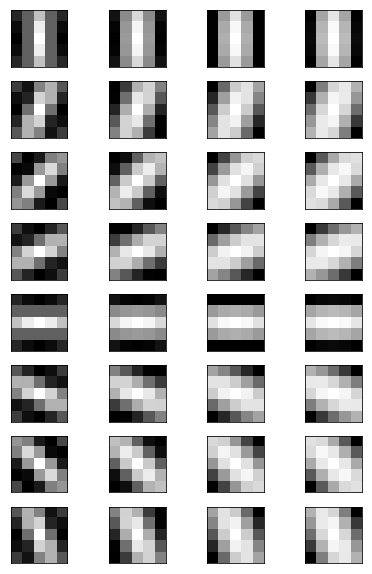

In [64]:
fig, axes = plt.subplots(8,4)
plt.subplots_adjust(top=2, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
for i, ax in enumerate(axes.flat):
    img = weights[0,i, :, :]
    ax.imshow(img,cmap='gray')
    #ax.colorbar()
    ax.set_xticks([])
    ax.set_yticks([])
    


In [65]:
for m in range(1,5):
    w = math.pi/2*(2**0.5)**(-m+1)
    sigma = math.pi/w
    print(w)

1.5707963267948966
1.1107207345395915
0.7853981633974482
0.5553603672697957
